## LR + SHAP

In [1]:
import re, numpy as np, pandas as pd, shap, warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

warnings.filterwarnings("ignore", category=UserWarning)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CSV_PATH = "/Users/merterol/Desktop/UZH/CompLing:CompSci/CL/Sem 5/Bachelors Thesis/VSCode/Bachelors-Thesis/data/merged.csv"
RANDOM_STATE = 42
TEST_SIZE = 0.2
SHAP_SAMPLE_SIZE = 500  # Number of samples to use for SHAP analysis

In [13]:
def extract_sender_domain(sender: str) -> str:
    if not isinstance(sender, str) or sender.strip() == "":
        return "no_sender"
    m = re.search(r'@([a-zA-Z0-9.-]+)', sender)
    return m.group(1).lower() if m else "unknown_format"

def pick_positive_class_index(classes):
    classes_list = list(classes)
    if len(classes_list) == 2:
        if "spam" in classes_list: return classes_list.index("spam")
        if 1 in classes_list:      return classes_list.index(1)
        return 1
    return 0

In [14]:
df = pd.read_csv(CSV_PATH).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
df["sender"] = df["sender"].fillna("")
df["text"] = df["text"].fillna("")
X = df[["sender", "text"]].copy()
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE,
    stratify=y if y.nunique() > 1 else None
)

# add sender_domain
for frame in (X_train, X_test):
    frame["sender_domain"] = frame["sender"].apply(extract_sender_domain)

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ("text",   TfidfVectorizer(max_features=30000, min_df=2, stop_words="english"), "text"),
        ("sender", TfidfVectorizer(max_features=2000,  min_df=2),                       "sender_domain"),
    ],
    remainder="drop"
)

# ---- Model: LogisticRegression handles sparse natively (fast!)
clf = LogisticRegression(
    solver="saga",  # sparse + multinomial capable
    penalty="l2",
    C=1.0,
    max_iter=1000,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", clf)])
pipeline.fit(X_train, y_train)

# ---- Eval
y_pred = pipeline.predict(X_test)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     12150
           1       0.98      0.99      0.99     13530

    accuracy                           0.99     25680
   macro avg       0.99      0.99      0.99     25680
weighted avg       0.99      0.99      0.99     25680



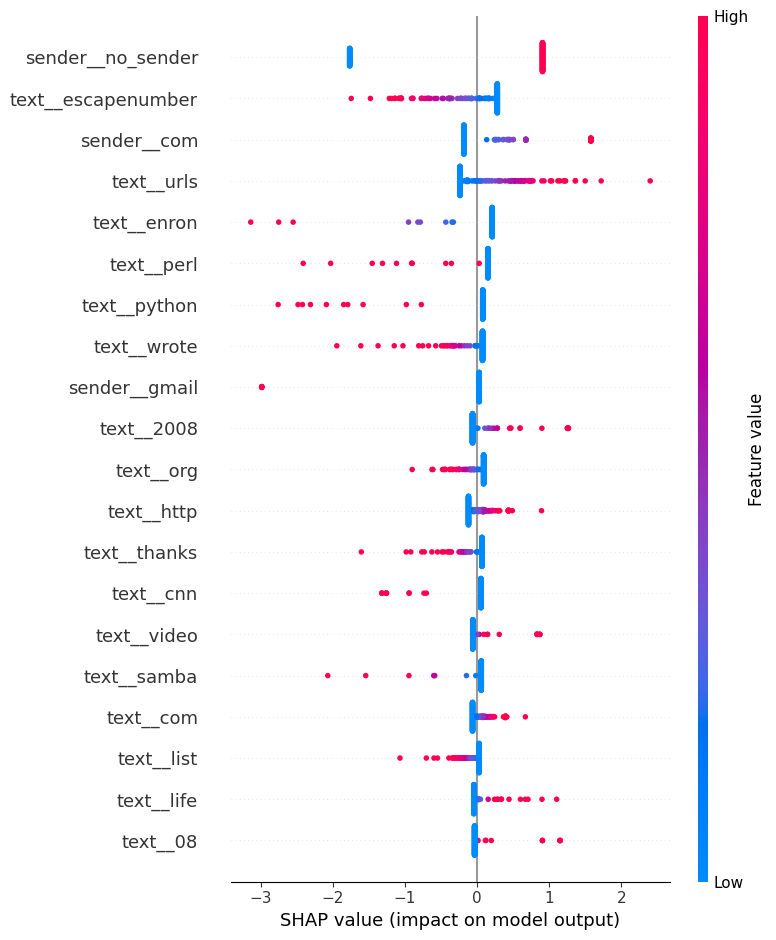

In [16]:
fitted_preprocessor = pipeline.named_steps["preprocessor"]
fitted_clf = pipeline.named_steps["classifier"]
X_test_tx = fitted_preprocessor.transform(X_test)   # stays sparse
n_samples = min(SHAP_SAMPLE_SIZE, X_test_tx.shape[0])
X_shap = X_test_tx[:n_samples]

# Background for LinearExplainer (small slice of training set)
X_bg = fitted_preprocessor.transform(X_train[:200])

shap.initjs()
explainer = shap.LinearExplainer(fitted_clf, X_bg)  # sparse-friendly
shap_values = explainer.shap_values(X_shap)         # returns sparse/dense depending on SHAP version

# Feature names
try:
    feature_names = fitted_preprocessor.get_feature_names_out()
except Exception:
    feature_names = None

# Convert to a 2D dense for plotting only the selected rows (small -> okay)
if hasattr(X_shap, "toarray"):
    X_plot = X_shap.toarray()
else:
    X_plot = np.asarray(X_shap)

# Binary: shap_values is array; Multiclass: list of arrays
pos_idx = pick_positive_class_index(getattr(fitted_clf, "classes_", [0, 1]))
if isinstance(shap_values, list):  # multiclass shape
    sv_plot = shap_values[pos_idx]
else:
    sv_plot = shap_values

import matplotlib.pyplot as plt
plt.figure()
shap.summary_plot(sv_plot, X_plot, feature_names=feature_names, show=True)

- Red to the right = presence of that feature increases spam probability.
- Red to the left = presence of that feature decreases spam probability.
- Blue to the opposite side = absence of the feature has the inverse effect.

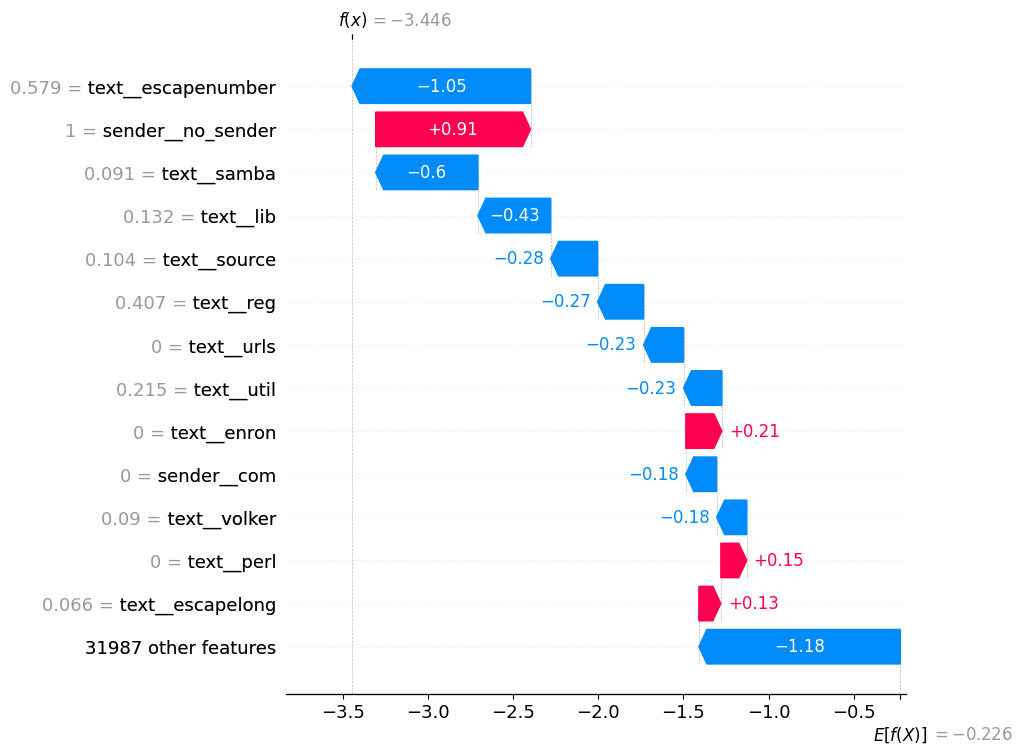

In [ ]:
sample_idx = 0  # index of the sample to explain
explanation = shap.Explanation(
	values=shap_values[sample_idx],
	base_values=explainer.expected_value,
	data=X_plot[sample_idx],
	feature_names=feature_names
)
shap.plots.waterfall(explanation, max_display=14)

In [7]:
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

SHAP_SAMPLE_SIZE = 200     # fewer rows for RF SHAP
SVD_COMPONENTS = 300

def extract_sender_domain(sender: str) -> str:
    if not isinstance(sender, str) or sender.strip() == "":
        return "no_sender"
    m = re.search(r'@([a-zA-Z0-9.-]+)', sender)
    return m.group(1).lower() if m else "unknown_format"

df = pd.read_csv(CSV_PATH).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
df["sender"] = df["sender"].fillna("")
df["text"] = df["text"].fillna("")
X = df[["sender", "text"]].copy()
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y if y.nunique() > 1 else None
)

for frame in (X_train, X_test):
    frame["sender_domain"] = frame["sender"].apply(extract_sender_domain)

# Vectorize then reduce with SVD (keeps things numeric & small)
vectorizer = ColumnTransformer(
    transformers=[
        ("text",   TfidfVectorizer(max_features=50000, min_df=2, stop_words="english"), "text"),
        ("sender", TfidfVectorizer(max_features=2000,  min_df=2),                        "sender_domain"),
    ]
)

pipeline = Pipeline([
    ("vec", vectorizer),
    ("svd", TruncatedSVD(n_components=SVD_COMPONENTS, random_state=RANDOM_STATE)),
    ("rf",  RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=RANDOM_STATE)),
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:590: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:590: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:590: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     12150
           1       0.98      0.99      0.99     13530

    accuracy                           0.98     25680
   macro avg       0.98      0.98      0.98     25680
weighted avg       0.98      0.98      0.98     25680



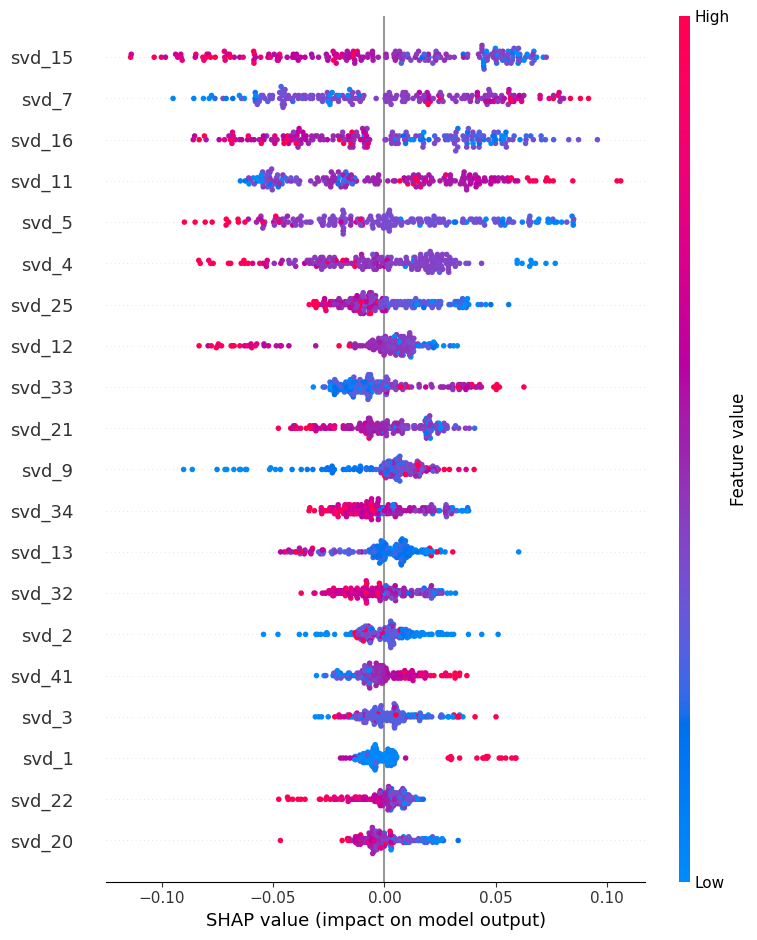

In [9]:
X_test_red = pipeline.named_steps["svd"].transform(
    pipeline.named_steps["vec"].transform(X_test)
)

n_samples = min(SHAP_SAMPLE_SIZE, X_test_red.shape[0])
X_shap = X_test_red[:n_samples]

shap.initjs()
rf = pipeline.named_steps["rf"]
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_shap)

# Plot (features are unnamed SVD components)
import matplotlib.pyplot as plt
feat_names = [f"svd_{i}" for i in range(X_shap.shape[1])]
pos_idx = 1 if getattr(rf, "n_classes_", 2) == 2 else 0

plt.figure()
# For multiclass, select the SHAP values for the positive class (pos_idx)
if shap_values.ndim == 3:
    shap.summary_plot(shap_values[:, :, pos_idx], X_shap, feature_names=feat_names, show=True)
else:
    shap.summary_plot(shap_values, X_shap, feature_names=feat_names, show=True)

In [11]:
vec = pipeline.named_steps["vec"]
svd = pipeline.named_steps["svd"]

terms = vec.get_feature_names_out()
comp = svd.components_

# all svd components
for i in range(comp.shape[0]):
    terms_comp = sorted(zip(terms, comp[i]), key=lambda x: x[1], reverse=True)[:10]
    print(f"\n=== SVD Component {i} ===")
    for term, val in terms_comp:
        print(f"{term}: {val:.4f}")
        
print("----------------------------------")
print("Top SVD Components")
print("----------------------------------")

# top svd components
for i in [15, 7, 16, 11]:
    terms_comp = sorted(zip(terms, comp[i]), key=lambda x: x[1], reverse=True)[:10]
    print(f"\n=== SVD Component {i} ===")
    for term, val in terms_comp:
        print(f"{term}: {val:.4f}")


=== SVD Component 0 ===
sender__no_sender: 0.9811
text__escapenumber: 0.1617
text__escapelong: 0.0272
text__http: 0.0198
text__com: 0.0176
text__www: 0.0135
text__enron: 0.0131
text__help: 0.0120
text__org: 0.0116
text__ect: 0.0112

=== SVD Component 1 ===
sender__com: 0.9475
text__cnn: 0.1255
sender__gmail: 0.1081
text__com: 0.1040
text__urls: 0.0703
text__2008: 0.0697
text__http: 0.0674
text__index: 0.0667
text__html: 0.0578
text__video: 0.0545

=== SVD Component 2 ===
text__escapenumber: 0.9668
text__samba: 0.0459
text__escapenumbermg: 0.0331
text__price: 0.0256
text__retail: 0.0254
text__stat: 0.0239
text__pills: 0.0238
text__ethz: 0.0237
text__branches: 0.0231
text__ch: 0.0230

=== SVD Component 3 ===
sender__org: 0.6524
text__cnn: 0.3551
sender__net: 0.2031
text__2008: 0.1681
text__com: 0.1593
text__video: 0.1520
text__index: 0.1458
text__08: 0.1407
text__html: 0.1330
text__www: 0.1293

=== SVD Component 4 ===
sender__org: 0.4760
sender__gmail: 0.3773
text__python: 0.2206
text__